# TFRecord Parsing & Data Pipeline

In [8]:
# ================================
# 1 Imports & Global Config
# ================================
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input, mixed_precision
import umap.umap_ as umap
import seaborn as sns

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Use mixed precision for faster training on GPUs
mixed_precision.set_global_policy('mixed_float16')


# Paths & Dataset Parameters
DATA_PATH = "/home/akokholm/mnt/SUN-BMI-EC-AKOKHOLM/Master-BMI/GitHub_Repository/" \
            "Project_of_Anton_-_Unsupervised_Deep_Learning_of_ECGs_Exploring_the_Latent_Space/" \
            "Data/MIMIC-IV/mimic_chunk_*.tfrecord"

EXPECTED_SHAPE = (5000, 8)
BATCH_SIZE = 256
SHUFFLE_BUFFER = 20000


# TFRecord Parsing & Data Pipeline

In [9]:
# ================================
# 2 TFRecord Parsing Function
# ================================
feature_description = {"ecg": tf.io.FixedLenFeature([], tf.string)}

def parse_example(example_proto):
    """Parse a single TFRecord example into (input, target) pair."""
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    ecg = tf.io.decode_raw(parsed["ecg"], out_type=tf.float32)
    ecg = tf.reshape(ecg, EXPECTED_SHAPE)
    
    # --- Z-Score Normalization per lead ---
    # Transforms data to have a mean of 0 and a standard deviation of 1 for each lead.
    means = tf.reduce_mean(ecg, axis=0, keepdims=True)
    stds = tf.math.reduce_std(ecg, axis=0, keepdims=True)
    # (X - Mean) / (StdDev + epsilon)
    # 1e-8 prevents crashing if a lead is a pure flatline (std = 0)
    ecg = (ecg - means) / (stds + 1e-8)
    # ==========================================

    return ecg, ecg  # Input = Target for Autoencoder

# ================================
# 3 Dataset Creation
# ================================
def create_dataset(file_pattern=DATA_PATH, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER):
    files = tf.io.gfile.glob(file_pattern)
    files.sort()
    print(f"Found {len(files)} TFRecord files.")

    dataset = tf.data.TFRecordDataset(files, num_parallel_reads=tf.data.AUTOTUNE)
    dataset = dataset.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)

    # Optimization
    #dataset = dataset.cache()  # Keep dataset in RAM if possible
    dataset = dataset.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Initialize dataset
train_dataset = create_dataset()


Found 17 TFRecord files.


# Autoencoder Architecture

In [10]:
# ================================
# 4 Autoencoder Model
# ================================
def build_autoencoder(input_shape, latent_dim=64, use_layernorm=False):
    inputs = Input(shape=input_shape)
    
    # --- ENCODER ---
    x = layers.Conv1D(32, 5, strides=2, padding='same', activation='relu')(inputs)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    x = layers.Conv1D(64, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    x = layers.Conv1D(128, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    # --- LATENT SPACE ---
    shape_before_flatten = x.shape[1:]
    x = layers.Flatten()(x)
    latent = layers.Dense(latent_dim, name='latent_space')(x)

    # --- DECODER ---
    units = int(np.prod(shape_before_flatten))
    x = layers.Dense(units)(latent)
    x = layers.Reshape(shape_before_flatten)(x)
    x = layers.ReLU()(x)

    x = layers.Conv1DTranspose(128, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    x = layers.Conv1DTranspose(64, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    x = layers.Conv1DTranspose(32, 5, strides=2, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x) if use_layernorm else layers.BatchNormalization()(x)

    outputs = layers.Conv1D(input_shape[-1], 1, padding='same', activation='linear')(x)
    return models.Model(inputs, outputs)

# Build & compile model
latent_dim = 64
autoencoder = build_autoencoder(EXPECTED_SHAPE, latent_dim, use_layernorm=True)
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    jit_compile=False
)

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 5000, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2500, 32)       │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 2500, 32)       │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1250, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 1250, 64)       │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 625, 128)       │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 625, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 64)             │     5,120,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80000)          │     5,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 625, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 1250, 128)      │        82,048 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 1250, 128)      │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 2500, 64)       │        41,024 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 2500, 64)       │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 5000, 32)       │        10,272 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 5000, 32)       │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 5000, 8)        │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,507,272 (40.08 MB)

 Trainable params: 10,507,272 (40.08 MB)

 Non-trainable params: 0 (0.00 B)

# Training

In [11]:
# ================================
# 5 Training Setup
# ================================
# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Split validation dataset (~1000 ECGs)
VAL_BATCHES = 16
validation_dataset = train_dataset.take(VAL_BATCHES)
train_dataset_final = train_dataset.skip(VAL_BATCHES)

# Train model
history = autoencoder.fit(
    train_dataset_final,
    validation_data=validation_dataset,
    epochs=500,
    callbacks=[early_stopping],
    verbose=2
)


Epoch 1/500


2026-02-15 19:39:22.476765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 7221 of 20000
2026-02-15 19:39:39.851923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2026-02-15 19:39:46.010937: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90700
2026-02-15 19:57:43.114642: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/akokholm/.virtualenvs/ecg_project_env/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2026-02-15 19:57:53.543087: I tensor

3109/3109 - 1150s - 370ms/step - loss: 0.4113 - val_loss: 0.2502
Epoch 2/500


KeyboardInterrupt: 

# Visualizations

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step 


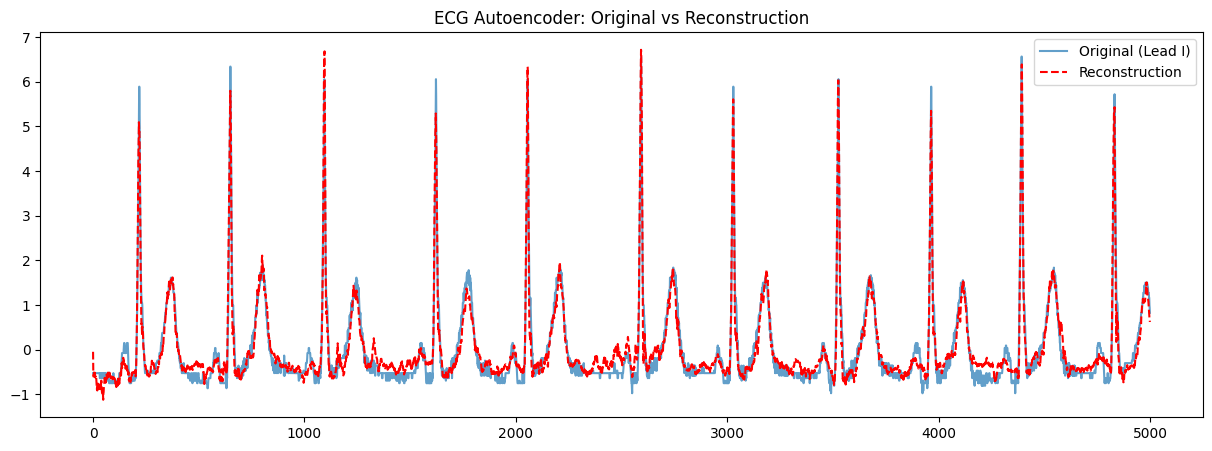

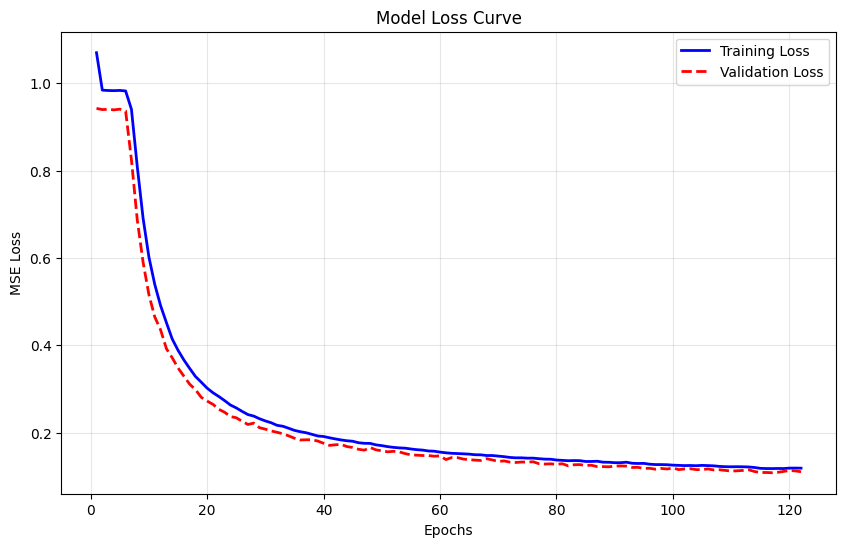

1. Gathering predictions for error analysis...
   Analyzed 1024 ECGs.


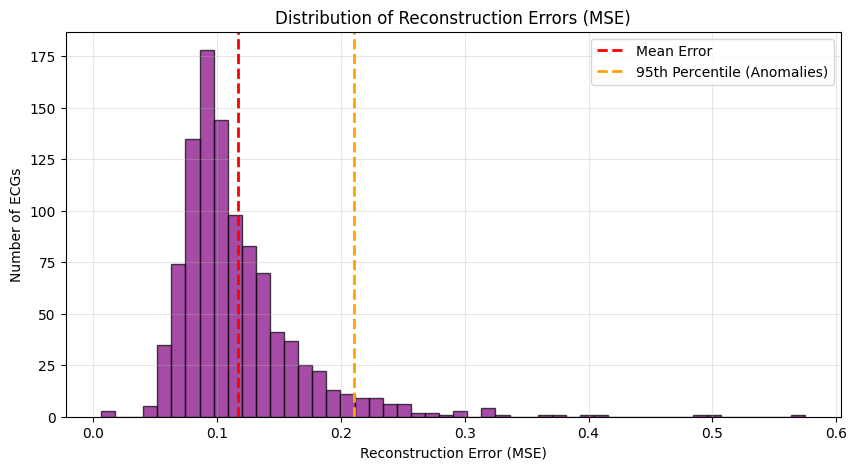

Lowest Error (Most 'Normal'): 0.00654
Highest Error (Most 'Anomalous'): 0.57499


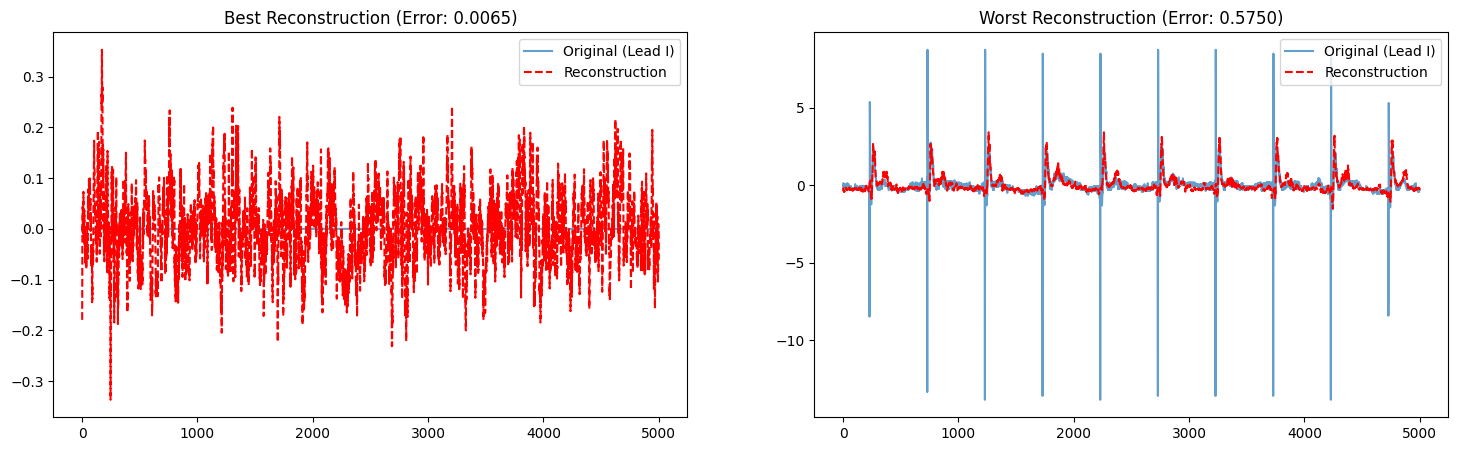

1. Extracting Encoder...
2. Gathering ECG data...
   Collected 1024 ECGs.
3. Generating 64D Latent Representations...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4. Fitting UMAP (Reducing 64D -> 2D)...


/home/akokholm/.virtualenvs/ecg_project_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


5. Plotting...


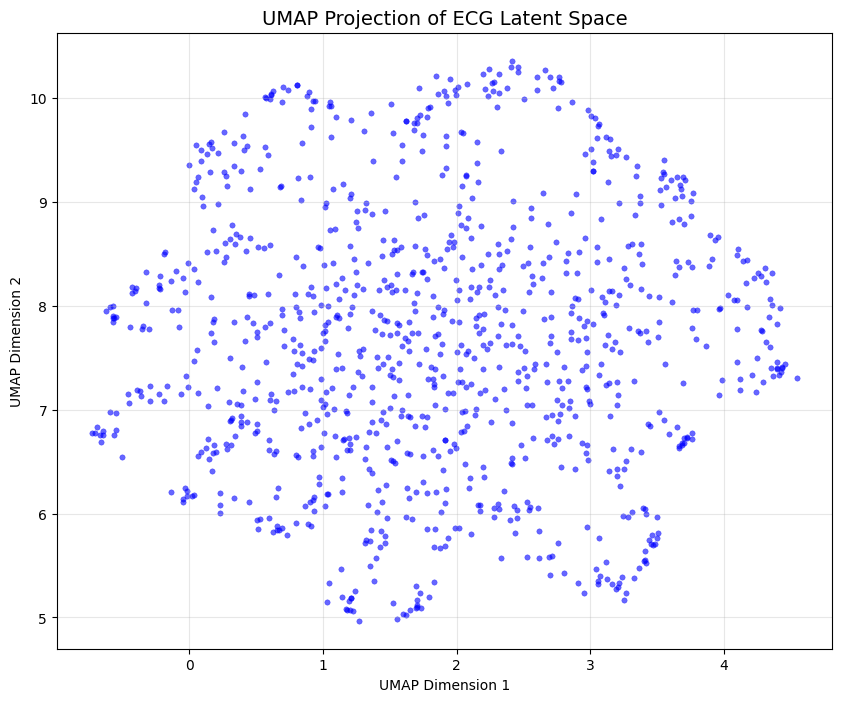

In [5]:
# ================================
# 6 Plot Reconstruction of a Single ECG
# ================================
def plot_reconstruction(dataset, model):
    for x_batch, _ in dataset.take(1):
        reconstructed = model.predict(x_batch)
        plt.figure(figsize=(15, 5))
        plt.plot(x_batch[0, :, 0], label="Original (Lead I)", alpha=0.7)
        plt.plot(reconstructed[0, :, 0], label="Reconstruction", color='red', linestyle='--')
        plt.title("ECG Autoencoder: Original vs Reconstruction")
        plt.legend()
        plt.show()
        break

plot_reconstruction(train_dataset, autoencoder)

# ================================
# 7 Training Loss Curve
# ================================
def plot_training_history(history):
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'b-', label='Training Loss', linewidth=2)
    
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'r--', label='Validation Loss', linewidth=2)
    
    plt.title('Model Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_training_history(history)

# ================================
# 8 Anomaly Detection (Error Distribution)
# ================================
def analyze_reconstruction_errors(model, dataset, num_batches=16):
    print("1. Gathering predictions for error analysis...")
    real_ecgs = []
    reconstructed_ecgs = []
    
    # Collect data
    for x_batch, _ in dataset.take(num_batches):
        real_ecgs.append(x_batch.numpy())
        reconstructed_ecgs.append(model.predict(x_batch, verbose=0))
        
    real_ecgs = np.concatenate(real_ecgs, axis=0)
    reconstructed_ecgs = np.concatenate(reconstructed_ecgs, axis=0)
    
    print(f"   Analyzed {real_ecgs.shape[0]} ECGs.")
    
    # 2. Calculate Mean Squared Error PER SAMPLE
    # We average the error across the 5000 timesteps and 12 leads (axis 1 and 2)
    mse_per_sample = np.mean(np.square(real_ecgs - reconstructed_ecgs), axis=(1, 2))
    
    # 3. Plot the Error Distribution Histogram
    plt.figure(figsize=(10, 5))
    plt.hist(mse_per_sample, bins=50, color='purple', alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(mse_per_sample), color='red', linestyle='dashed', linewidth=2, label='Mean Error')
    
    # Define an "Anomaly Threshold" (e.g., 95th percentile)
    threshold = np.percentile(mse_per_sample, 95)
    plt.axvline(threshold, color='orange', linestyle='dashed', linewidth=2, label='95th Percentile (Anomalies)')
    
    plt.title('Distribution of Reconstruction Errors (MSE)')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Number of ECGs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 4. Find the Best and Worst Reconstructions
    best_idx = np.argmin(mse_per_sample)  # Lowest error
    worst_idx = np.argmax(mse_per_sample) # Highest error
    
    print(f"Lowest Error (Most 'Normal'): {mse_per_sample[best_idx]:.5f}")
    print(f"Highest Error (Most 'Anomalous'): {mse_per_sample[worst_idx]:.5f}")
    
    # 5. Plot the Best vs Worst
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    
    # Plot Best (Normal)
    axes[0].plot(real_ecgs[best_idx, :, 0], label="Original (Lead I)", alpha=0.7)
    axes[0].plot(reconstructed_ecgs[best_idx, :, 0], label="Reconstruction", color='red', linestyle='--')
    axes[0].set_title(f"Best Reconstruction (Error: {mse_per_sample[best_idx]:.4f})")
    axes[0].legend()
    
    # Plot Worst (Anomaly)
    axes[1].plot(real_ecgs[worst_idx, :, 0], label="Original (Lead I)", alpha=0.7)
    axes[1].plot(reconstructed_ecgs[worst_idx, :, 0], label="Reconstruction", color='red', linestyle='--')
    axes[1].set_title(f"Worst Reconstruction (Error: {mse_per_sample[worst_idx]:.4f})")
    axes[1].legend()
    
    plt.show()

# Run the analysis on the validation dataset
analyze_reconstruction_errors(autoencoder, validation_dataset, num_batches=VAL_BATCHES)


# ================================
# 9 UMAP Visualization of Latent Space
# ================================
def visualize_latent_space(model, dataset, num_batches=10):
    print("1. Extracting Encoder...")
    # Create a sub-model that outputs the 'latent_space' layer
    encoder = models.Model(
        inputs=model.input, 
        outputs=model.get_layer('latent_space').output
    )
    
    print("2. Gathering ECG data...")
    # Gather a subset of data (e.g., from the validation set)
    ecg_samples = []
    for x_batch, _ in dataset.take(num_batches):
        ecg_samples.append(x_batch.numpy())
    
    # Concatenate batches into a single numpy array
    ecg_samples = np.concatenate(ecg_samples, axis=0)
    print(f"   Collected {ecg_samples.shape[0]} ECGs.")
    
    print("3. Generating 64D Latent Representations...")
    latent_vectors = encoder.predict(ecg_samples, verbose=1)
    
    print("4. Fitting UMAP (Reducing 64D -> 2D)...")
    # You can tweak n_neighbors (local vs global structure) and min_dist (tightness of clusters)
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    umap_embeddings = reducer.fit_transform(latent_vectors)
    
    print("5. Plotting...")
    plt.figure(figsize=(10, 8))
    
    # Since this is unsupervised and we don't have labels parsed yet, 
    # we just plot the density/distribution of the points.
    sns.scatterplot(
        x=umap_embeddings[:, 0], 
        y=umap_embeddings[:, 1], 
        alpha=0.6, 
        edgecolor=None,
        s=15,
        color='b'
    )
    
    plt.title('UMAP Projection of ECG Latent Space', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the visualization on a chunk of the validation dataset
visualize_latent_space(autoencoder, validation_dataset, num_batches=16)